# Efecto de régimen de dosificación en PTA

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

from keras.wrappers.scikit_learn import KerasRegressor

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import numpy as np
import pandas as pd

from matplotlib import cm, ticker
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import datasets
from google.colab import files

In [2]:
!pip install eli5
!pip install shap
import eli5
from eli5.sklearn import PermutationImportance
import shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 5.5 MB/s 
     |████████████████████████████████| 133 kB 39.8 MB/s 
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=b6794863155facdd5a4d7ef5d8f1faee207b1c796441cd9c241ce801a34cb824
  Stored in directory: /root/.cache/pip/wheels/cc/3c/96/3ead31a8e6c20fc0f1a707fde2e05d49a80b1b4b30096573be
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.1.2 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 5.0 MB/s 


In [3]:
data = pd.read_csv('evaluacionRegimenes.csv')
data.head()

,DD,II,CLCR,tinf,AUC_target,cmin_target
0,1185.305203,19.236983,84.226350,9.608313,0.077,0.011
1,3541.546326,14.081303,87.032767,5.227802,0.016,0.294
2,1234.332791,22.438600,124.368494,19.408171,0.014,0.001
3,1486.408638,23.363598,81.917308,10.042260,0.473,0.032
4,2659.989257,7.755189,102.635475,6.783882,0.417,0.232


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DD           3000 non-null   float64
 1   II           3000 non-null   float64
 2   CLCR         3000 non-null   float64
 3   tinf         3000 non-null   float64
 4   AUC_target   3000 non-null   float64
 5   cmin_target  3000 non-null   float64
dtypes: float64(6)
memory usage: 140.8 KB


Se seleccionan a las variables `DD`, `ii`, `tinf`, `CLCR`, y `MIC`, como variables dependientes, se conoce por gráficos marginales que `ii`, `tinf`, y `CLCR` aportan poca información sobre el indicador PK-PD reportado en la columna `mn` (AUC/MIC >= 400).

In [5]:
X  = data.loc[:, ['DD', 'II', 'tinf', 'CLCR']]
y1 = data.AUC_target
y2 = data.cmin_target
Y  = np.array([y1.ravel(), y2.ravel()]).T

In [6]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(X))

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

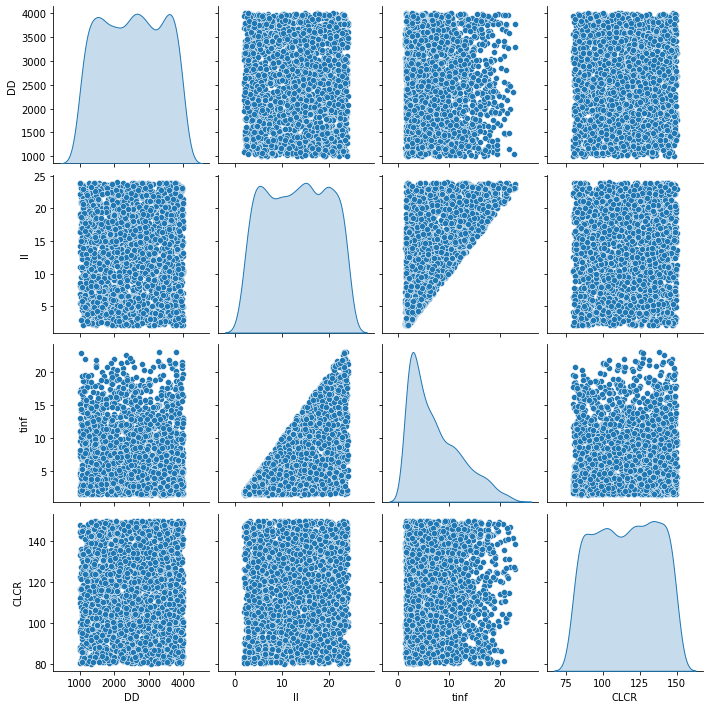

In [8]:
sns.pairplot(X_train, diag_kind='kde');

## Modelo
Ahora se especifica la configuración de la red neuronal artificial, mediante la librería `Keras`.

In [9]:
def regresorKeras(nodosInicio = 5, listaOculta = []):
  # Inicio de modelo
  model = tf.keras.models.Sequential([normalizer])
  # Capa de entrada
  model.add(tf.keras.layers.Dense(nodosInicio, activation=tf.nn.relu, input_shape=(X_train.shape[1],), name = 'Entrada'))
  # Capas ocultas
  for nombre, nodos in enumerate(listaOculta):
    model.add(tf.keras.layers.Dense(nodos, activation=tf.nn.relu, name = 'Oculta_{0}'.format(nombre + 1)))
  
  # Capa de salida
  # Se seleccionan dos neuronas de salida: indicador: AUC/MIC > 400 & <600, Cmin entre 15 y 20mg/L
  # La capa de salida sólo permite valores de 0 a 1 se usa fun sigmoidea
  model.add(tf.keras.layers.Dense(2, activation = tf.nn.sigmoid, name = 'Salida')) 
  
  model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
    loss = 'mean_absolute_error', metrics = ['mae', 'mape', 'mean_squared_error'])
  return model; 

In [10]:
%%time
# Especificación de parada temprana
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=30, min_delta=1e-10)

# Especificación de arquitecturas ANN
estimatorA = KerasRegressor(build_fn=regresorKeras, batch_size=256, epochs=1000, validation_data=(X_test.values, y_test), verbose=0, callbacks = [callback], listaOculta = [10])
estimatorB = KerasRegressor(build_fn=regresorKeras, batch_size=256, epochs=1000, validation_data=(X_test.values, y_test), verbose=0, callbacks = [callback], listaOculta = [10,10])
estimatorC = KerasRegressor(build_fn=regresorKeras, batch_size=256, epochs=1000, validation_data=(X_test.values, y_test), verbose=0, callbacks = [callback], listaOculta = [10,10,10])
estimatorD = KerasRegressor(build_fn=regresorKeras, batch_size=256, epochs=1000, validation_data=(X_test.values, y_test), verbose=0, callbacks = [callback], listaOculta = [10,10,10,10])

CPU times: user 4.81 ms, sys: 0 ns, total: 4.81 ms
Wall time: 8.34 ms


KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


In [11]:
# Guardar la historia de entrenamiento
historiaA = estimatorA.fit(X_train.values, y_train)
historiaB = estimatorB.fit(X_train.values, y_train)
historiaC = estimatorC.fit(X_train.values, y_train)
historiaD = estimatorD.fit(X_train.values, y_train)

In [12]:
historiaD.model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 4)                9         
 n)                                                              
                                                                 
 Entrada (Dense)             (None, 5)                 25        
                                                                 
 Oculta_1 (Dense)            (None, 10)                60        
                                                                 
 Oculta_2 (Dense)            (None, 10)                110       
                                                                 
 Oculta_3 (Dense)            (None, 10)                110       
                                                                 
 Oculta_4 (Dense)            (None, 10)                110       
                                                      

In [13]:
# histDF = pd.DataFrame(history.history)
# histDF['epoch'] = history.epoch
# histDF.tail()
# historiaA

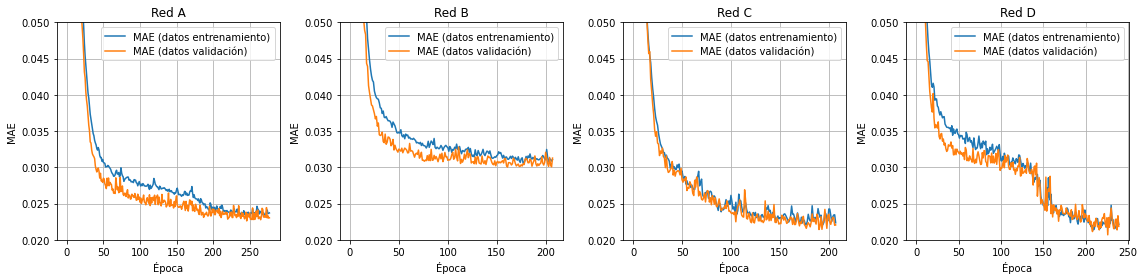

In [14]:
fig, axs = plt.subplots(1, 4, figsize = (16, 4))
listaHistorias = [eval('historia{}'.format(i)) for i in ['A', 'B', 'C', 'D']]
listaNombre = ['Red {}'.format(i) for i in ['A', 'B', 'C', 'D']]

for ax, hist, nombre in zip(axs, listaHistorias, listaNombre):
  ax.plot(hist.history['loss'], label='MAE (datos entrenamiento)')
  ax.plot(hist.history['val_loss'], label='MAE (datos validación)')
  ax.axis(ymin = 0.02, ymax = 0.05)
  ax.set_xlabel('Época')
  ax.set_ylabel('MAE')
  ax.set_title(nombre)
  ax.legend()
  ax.grid(True)

fig.set_tight_layout(True)

plt.savefig('./100_Error_Entrenamiento_ANN_MAE.pdf')

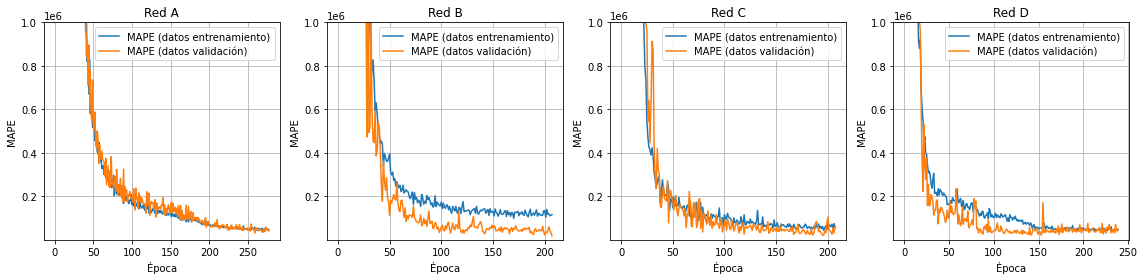

In [15]:
fig, axs = plt.subplots(1, 4, figsize = (16, 4))
listaHistorias = [eval('historia{}'.format(i)) for i in ['A', 'B', 'C', 'D']]
listaNombre = ['Red {}'.format(i) for i in ['A', 'B', 'C', 'D']]

for ax, hist, nombre in zip(axs, listaHistorias, listaNombre):
  ax.plot(hist.history['mape'], label='MAPE (datos entrenamiento)')
  ax.plot(hist.history['val_mape'], label='MAPE (datos validación)')
  ax.axis(ymin = 1, ymax = 1e6)
  ax.set_xlabel('Época')
  ax.set_ylabel('MAPE')
  ax.set_title(nombre)
  ax.legend()
  ax.grid(True)

fig.set_tight_layout(True)

plt.savefig('./100_Error_Entrenamiento_ANN_MAPE.pdf')

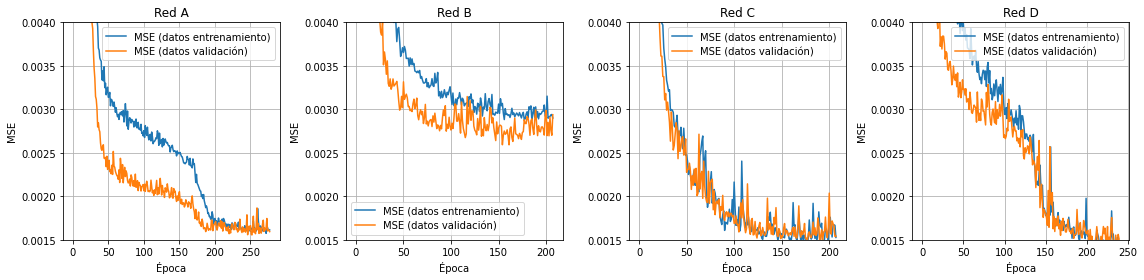

In [16]:
fig, axs = plt.subplots(1, 4, figsize = (16, 4))
listaHistorias = [eval('historia{}'.format(i)) for i in ['A', 'B', 'C', 'D']]
listaNombre = ['Red {}'.format(i) for i in ['A', 'B', 'C', 'D']]

for ax, hist, nombre in zip(axs, listaHistorias, listaNombre):
  ax.plot(hist.history['mean_squared_error'], label='MSE (datos entrenamiento)')
  ax.plot(hist.history['val_mean_squared_error'], label='MSE (datos validación)')
  ax.axis(ymin = 0.0015, ymax = 0.004)
  ax.set_xlabel('Época')
  ax.set_ylabel('MSE')
  ax.set_title(nombre)
  ax.legend()
  ax.grid(True)

fig.set_tight_layout(True)

plt.savefig('./100_Error_Entrenamiento_ANN_MSE.pdf')

In [17]:
listaRedes = ['A', 'B', 'C', 'D']
listaEstimadores = [eval("estimator{}".format(i)) for i in listaRedes]

listaPredicciones = list()

listaPredicciones.append( pd.DataFrame(y_train).rename(columns = {0: 'Obs_Entren__input1', 1: 'Obs_Entren__input2'}) )

for estim, nombre in zip(listaEstimadores, listaRedes):
  listaPredicciones.append( 
      pd.DataFrame(estim.predict(X_train)).rename(columns = {
          0: "Pred_Entren_{}_input1".format(nombre), 
          1: "Pred_Entren_{}_input2".format(nombre)})
      )

listaPredicciones.append( pd.DataFrame(y_test).rename(columns = {0: 'Obs_Prueba__input1', 1: 'Obs_Prueba__input2'}) )

for estim, nombre in zip(listaEstimadores, listaRedes):
  listaPredicciones.append( 
      pd.DataFrame(estim.predict(X_test)).rename(columns = {
          0: "Pred_Prueba_{}_input1".format(nombre), 
          1: "Pred_Prueba_{}_input2".format(nombre)})
      )

In [18]:
dfPredicciones = pd.concat(listaPredicciones, axis= 1)
dfPredicciones.head()

,Obs_Entren__input1,Obs_Entren__input2,Pred_Entren_A_input1,Pred_Entren_A_input2,Pred_Entren_B_input1,Pred_Entren_B_input2,Pred_Entren_C_input1,Pred_Entren_C_input2,Pred_Entren_D_input1,Pred_Entren_D_input2,Obs_Prueba__input1,Obs_Prueba__input2,Pred_Prueba_A_input1,Pred_Prueba_A_input2,Pred_Prueba_B_input1,Pred_Prueba_B_input2,Pred_Prueba_C_input1,Pred_Prueba_C_input2,Pred_Prueba_D_input1,Pred_Prueba_D_input2
0,0.067,0.304,0.031325,2.779154e-01,0.026916,1.834085e-01,0.024264,2.936034e-01,0.023054,2.951738e-01,0.645,0.115,0.628884,1.105851e-01,6.273555e-01,1.330754e-01,0.640455,1.104561e-01,0.636756,1.133956e-01
1,0.042,0.301,0.042383,2.918654e-01,0.043692,2.277662e-01,0.032401,3.019778e-01,0.032760,3.127169e-01,0.652,0.012,0.591456,8.904010e-03,5.880938e-01,5.503356e-03,0.642970,1.132861e-02,0.593251,1.093256e-02
2,0.000,0.000,0.000074,1.017307e-07,0.000016,1.441316e-08,0.000086,2.597841e-09,0.000059,6.996318e-13,0.059,0.001,0.054340,1.100749e-03,1.457003e-02,3.433526e-04,0.104811,8.199215e-04,0.032721,2.256763e-07
3,0.074,0.254,0.044628,2.449912e-01,0.038351,2.180294e-01,0.036908,2.594484e-01,0.033496,2.677158e-01,0.000,0.000,0.000004,5.784566e-12,4.338214e-07,7.420690e-12,0.000001,1.383538e-12,0.000017,9.163818e-16
4,0.579,0.245,0.477213,3.052275e-01,0.454160,2.632836e-01,0.480583,2.587444e-01,0.461152,2.887587e-01,0.081,0.174,0.082172,1.799002e-01,6.749672e-02,2.629506e-01,0.072506,1.970319e-01,0.068424,1.926063e-01


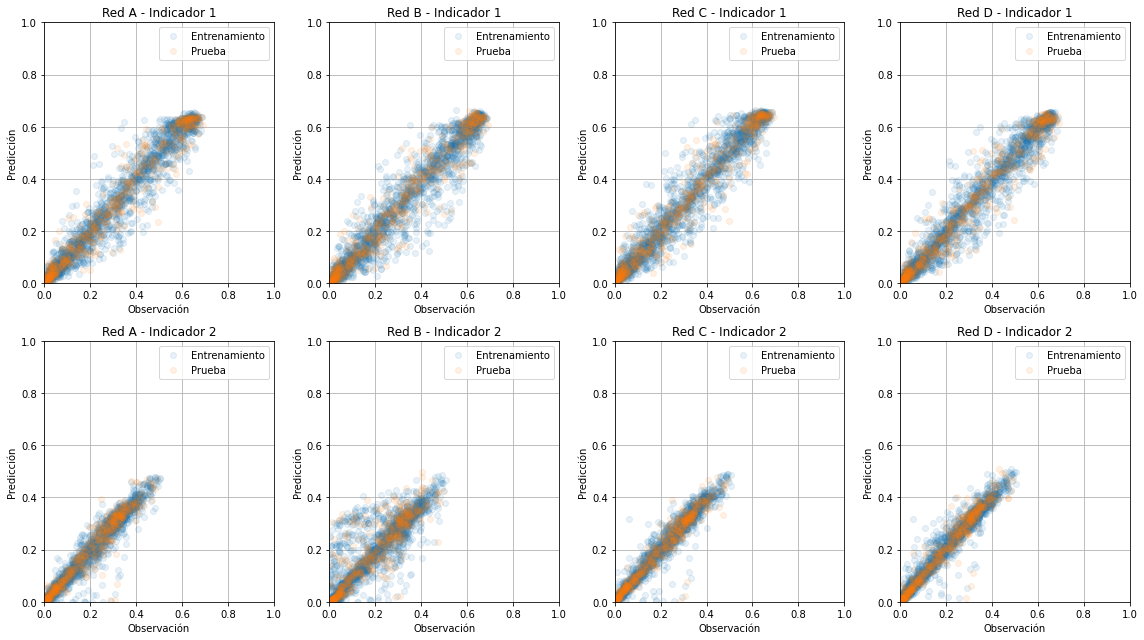

In [19]:
fig, axs = plt.subplots(2, 4, figsize = (16, 9))

for ax1 in range(2):  
  for ax2, title in zip(range(4), listaRedes):
    axs[ax1][ax2].plot('Obs_Entren__input{}'.format(ax1+1), 'Pred_Entren_{}_input{}'.format(title,ax1+1), 'o', 
                       data = dfPredicciones, label='Entrenamiento', alpha=0.1)
    axs[ax1][ax2].plot('Obs_Prueba__input{}'.format(ax1+1), 'Pred_Prueba_{}_input{}'.format(title,ax1+1), 'o', 
                       data = dfPredicciones, label='Prueba', alpha=0.1)
    axs[ax1][ax2].axis(ymin = 0, ymax = 1, xmin = 0, xmax=1)
    axs[ax1][ax2].set_xlabel('Observación')
    axs[ax1][ax2].set_ylabel('Predicción')
    axs[ax1][ax2].set_title('Red {} - Indicador {}'.format(title, ax1 + 1))
    axs[ax1][ax2].legend()
    axs[ax1][ax2].grid(True)

fig.set_tight_layout(True)
plt.savefig('./100_BondadAjuste_ANN.pdf')

In [20]:
df_erroresEntren = dfPredicciones.copy()
df_erroresPrueba = dfPredicciones.copy()

for tipo in ['Entren', 'Prueba']:
  
  x = eval("df_errores{}".format(tipo))

  for input in [1, 2]:
    obsTerm = "Obs_{0}__input{1}".format(tipo, input)

    for lsRed in listaRedes:
      errorTerm = "Error_{0}_{1}_input{2}".format(tipo, lsRed, input)
      predTerm  = "Pred_{0}_{1}_input{2}".format(tipo, lsRed, input)

      x[errorTerm] = x.loc[:, predTerm] - x.loc[:, obsTerm]

dfErrores = pd.concat([var.filter(like = 'Error').melt() for var in [df_erroresPrueba, df_erroresEntren]])

dfErrores[['tipo1', 'tipo2', 'modelo', 'input']] = dfErrores['variable'].str.split('_',expand=True)

dfErrores

,variable,value,tipo1,tipo2,modelo,input
0,Error_Prueba_A_input1,-0.016116,Error,Prueba,A,input1
1,Error_Prueba_A_input1,-0.060544,Error,Prueba,A,input1
2,Error_Prueba_A_input1,-0.004660,Error,Prueba,A,input1
3,Error_Prueba_A_input1,0.000004,Error,Prueba,A,input1
4,Error_Prueba_A_input1,0.001172,Error,Prueba,A,input1
...,...,...,...,...,...,...
19195,Error_Entren_D_input2,0.000346,Error,Entren,D,input2
19196,Error_Entren_D_input2,0.085704,Error,Entren,D,input2
19197,Error_Entren_D_input2,-0.036116,Error,Entren,D,input2
19198,Error_Entren_D_input2,0.037440,Error,Entren,D,input2


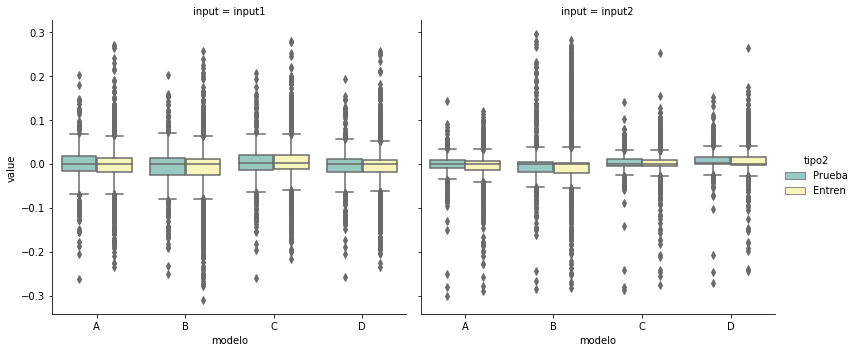

In [21]:
ax = sns.catplot(x = 'modelo', y = 'value', hue = 'tipo2', col='input', 
                 data = dfErrores, palette="Set3", kind = 'box', aspect = 1.1)
# ax.xaxis.grid(True)

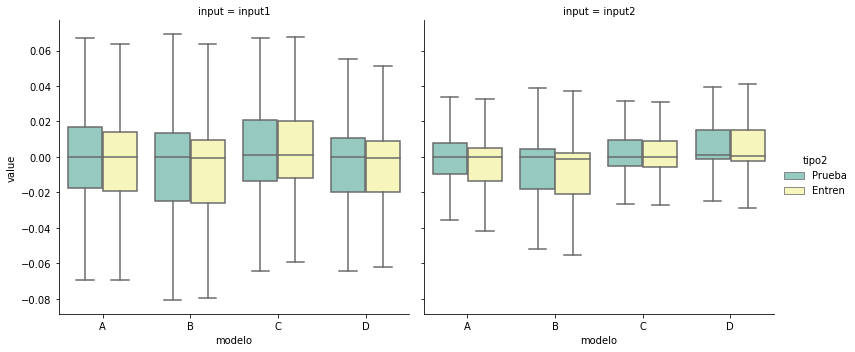

In [22]:
ax = sns.catplot(x = 'modelo', y = 'value', hue = 'tipo2', col='input', 
                 data = dfErrores, palette="Set3", kind = 'box', aspect = 1.1, showfliers = False)

In [23]:
dfErrores.groupby(['tipo2', 'input', 'modelo']).agg(
    MAE  = pd.NamedAgg(column = 'value', aggfunc = lambda x: np.mean(np.abs(x))),
    RMSE = pd.NamedAgg(column = 'value', aggfunc = lambda x: np.sqrt(np.mean(x**2)))
    ).reset_index().pivot(index = 'modelo', columns = ['tipo2', 'input'], values = ['MAE', 'RMSE'])

MAE                                    RMSE                      \
tipo2     Entren              Prueba              Entren              Prueba   
input     input1    input2    input1    input2    input1    input2    input1   
modelo                                                                         
A       0.029446  0.017220  0.029103  0.016972  0.046848  0.030576  0.046286   
B       0.032994  0.032322  0.030931  0.031615  0.054287  0.059897  0.049490   
C       0.030060  0.014816  0.029306  0.014805  0.048356  0.027372  0.047297   
D       0.028271  0.015946  0.028001  0.015699  0.046602  0.028789  0.045897   

                  
tipo2             
input     input2  
modelo            
A       0.032329  
B       0.058546  
C       0.029081  
D       0.030168

In [24]:
dfErrores.groupby(['tipo2', 'modelo']).agg(
    MAE  = pd.NamedAgg(column = 'value', aggfunc = lambda x: np.mean(np.abs(x))),
    RMSE = pd.NamedAgg(column = 'value', aggfunc = lambda x: np.sqrt(np.mean(x**2)))
    ).reset_index().pivot(index = 'modelo', columns = ['tipo2'], values = ['MAE', 'RMSE'])

MAE                RMSE          
tipo2     Entren    Prueba    Entren    Prueba
modelo                                        
A       0.023333  0.023037  0.039558  0.039922
B       0.032658  0.031273  0.057161  0.054207
C       0.022438  0.022056  0.039291  0.039260
D       0.022109  0.021850  0.038733  0.038837

In [25]:
estimator = estimatorB

In [26]:
estimator.model.save('model_002')

import shutil
shutil.make_archive('model_002', 'zip', 'model_002')
files.download('/content/model_002.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Creación de gráficos

In [27]:
def expand_grid(x, y, xval = 'x', yval = 'y'):
    xG, yG = np.meshgrid(x, y) # Crear malla
    xG = xG.flatten() # Hacer malla 1D
    yG = yG.flatten() # Igual
    return pd.DataFrame({xval:xG, yval:yG})

In [28]:
def PTAColorScalePlotly(color1 = 'rgb(255,32,3)', color2 = 'rgb(3,148, 252)', umbral=0.85):
  return [(0.00, color1), (umbral, color1), (umbral, color2), (1.00, color2)]

In [29]:
# sampleDF = expand_grid(np.linspace(-6, 6), np.linspace(15, 30), xval = 'MIC', yval = 'DD')
# sampleDF['ii'] = 6
# sampleDF['tinf'] = 2
# sampleDF['CLCR'] = 120
# sampleDF = sampleDF[['DD', 'ii', 'tinf', 'CLCR', 'MIC']]

In [30]:
objetoDict = {
  'DD': np.linspace(1500, 3000),
  'CLCR': np.linspace(80, 150),
  'ii': 6,
  'tinf': 2
}

ordenLista = ['DD', 'ii', 'tinf', 'CLCR']

def simularANN(variables, modelo, orden = ordenLista):
  dictArray  = [(i,k) for (i,k) in variables.items() if type(k) == np.ndarray]
  floatArray = [(i,k) for (i,k) in variables.items() if type(k) != np.ndarray]

  if len(dictArray) > 2:
    return
  
  sampleDF = expand_grid(dictArray[0][1], 
                        dictArray[1][1], 
                        xval = dictArray[0][0], 
                        yval = dictArray[1][0])

  for i in range(len(floatArray)):
    var, val = floatArray[i];
    sampleDF[var] = val

  sampleDF = sampleDF[orden]
  resultados = {'x': dictArray[0], 'y': dictArray[1], 'z': modelo.predict(sampleDF)}
  return resultados

In [31]:
DF = simularANN(objetoDict, estimator, ordenLista)

In [32]:
fig = make_subplots(rows=1, cols=2, 
                    specs=[[{'type': 'surface'}, {'type': 'surface'}]],
                    subplot_titles=("AUC 400-600", "Cmin 15-20"))

scene1 = {
    "xaxis": {"nticks": 5, 'title': 'Dosis diaria <br> (mg/día)'},
    "yaxis": {"nticks": 5, 'title': 'CLCR (mL/min/1.73m2)'},
    "zaxis": {"nticks": 2, 'range': [0, 1], 'title': 'PTA'},
    "aspectratio": {"x": 1, "y": 1, "z": 0.8},
    }

fig.add_trace(go.Surface(
    contours = {
        "x": {"show": True, "start": 1500, "end": 3000, "size": 500, "color":"white"},
        "y": {"show": True, "start": 80, "end": 150, "size": 10, "color":"white"},
        "z": {"show": True, "start": 0, "end": 1, "size": 0.1}
    },
    x = DF['x'][1],
    y = DF['y'][1],
    z = DF['z'][:, 0].reshape((50, 50)),
    cmin=0.0, cmax=1.0,
    customdata = [i for i in map(lambda m: 2**m, DF['x'][1])],
    hovertemplate = '<b>MIC</b>: %{x:.2f} <br><b>DD</b>: %{y} <br><b>PTA</b>: %{z:.2f}<br>',
    colorscale = PTAColorScalePlotly()
    ), row = 1, col = 1)
fig.update_layout(scene = scene1)

fig.add_trace(go.Surface(
    contours = {
        "y": {"show": True, "start": 80, "end": 150, "size": 1, "color":"white"},
        "x": {"show": True, "start": 1000, "end": 4000, "size": 5000, "color":"white"},
        "z": {"show": True, "start": 0, "end": 1, "size": 0.1}
    },
    x = DF['x'][1],
    y = DF['y'][1],
    z = DF['z'][:, 1].reshape((50, 50)),
    cmin=0.0, cmax=1.0,
    customdata = [i for i in map(lambda m: 2**m, DF['x'][1])],
    hovertemplate = '<b>MIC</b>: %{x:.2f} <br><b>DD</b>: %{y} <br><b>PTA</b>: %{z:.2f}<br>',
    colorscale = PTAColorScalePlotly()
    ), row = 1, col = 2)

fig.update_layout(scene2 = scene1)
fig.update_layout(title_text = 'Superficie de Respuesta - VAN II q6h, tinf 2 hr')

fig.show()

fig.write_html("101_superficiePTA_dosis_MIC1.html")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning:

overflow encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning:

overflow encountered in double_scalars



In [33]:
def PTAColorScaleMatplotlib(color1 = "#ff2103", color2 = "#0394fc", umbral=0.85):
  cmap = ListedColormap([color1, color1, color2, color2])
  bounds = [0.0, umbral, 1.0]
  norm = BoundaryNorm(bounds, cmap.N)

  return {'cmap': cmap, 'bounds': bounds, 'norm': norm}

In [34]:
def grafico3DSuperficie(x, y, z, newcmp, xlab = '', ylab = '', zlab = '', 
                        lim_opt = {'xlab': [-6, +6], 'ylab': [1500, 3000], 'zlab': [0,1]}, 
                        view_init_opt = {'elev': 10, 'azim': 12}):
  fig = plt.figure()
  ax = fig.gca(projection='3d')
  
  x1, y1 = np.meshgrid(x, y)

  ax.plot_surface(x1, y1, z, cmap=newcmp, linewidth=0, antialiased=False)
  ax.set_xlim(lim_opt['xlab'][0], lim_opt['xlab'][1])
  ax.set_ylim(lim_opt['ylab'][0], lim_opt['ylab'][1])
  ax.set_zlim(lim_opt['zlab'][0], lim_opt['zlab'][1])
  ax.set_xlabel(xlab)
  ax.set_ylabel(ylab)
  ax.set_zlabel(zlab)
  ax.view_init(elev = view_init_opt['elev'], azim = view_init_opt['azim']);
  return fig;

In [35]:
from matplotlib.colors import Normalize

norma1 = Normalize(vmin=0, vmax=1, clip=True)

def grafico3DContorno(ax, x, y, z, cmap, xlab = '', ylab = '', title='', 
                      levels = [0.0, 0.85, 1.00]):
  
  x1, y1 = np.meshgrid(x, y)
  main = ax.contourf(x1, y1, z, levels = levels, cmap=cmap, norm = norma1
                     #vmax=1, vmin=0
                     )
  ax.set_xlabel(xlab)
  ax.set_ylabel(ylab)
  ax.set_title(title)

  return main;

In [36]:
df = simularANN({'DD': np.linspace(1500, 3000), 'CLCR': np.linspace(80, 150), 'ii': 12, 'tinf': 4}, estimator, ordenLista)

fig = make_subplots(rows=1, cols=2, 
                    specs=[[{'type': 'surface'}, {'type': 'surface'}]],
                    subplot_titles=("AUC 400-600", "Cmin 15-20"))

scene1 = {
    "xaxis": {"nticks": 5, 'title': 'Dosis diaria <br> (mg/día)'},
    "yaxis": {"nticks": 5, 'title': 'CLCR (mL/min/1.73m2)'},
    "zaxis": {"nticks": 2, 'range': [0, 1], 'title': 'PTA'},
    "aspectratio": {"x": 1, "y": 1, "z": 0.8},
    }

fig.add_trace(go.Surface(
    contours = {
        "y": {"show": True, "start": 80, "end": 150, "size": 10, "color":"white"},
        "x": {"show": True, "start": 1500, "end": 3000, "size": 500, "color":"white"},
        "z": {"show": True, "start": 0, "end": 1, "size": 0.1}
    },
    x = df['x'][1],
    y = df['y'][1],
    z = df['z'][:, 0].reshape((50, 50)),
    cmin=0.0, cmax=1.0,
    customdata = [i for i in map(lambda m: 2**m, df['x'][1])],
    hovertemplate = '<b>MIC</b>: %{x:.2f} <br><b>DD</b>: %{y} <br><b>PTA</b>: %{z:.2f}<br>',
    colorscale = PTAColorScalePlotly()
    ), row = 1, col = 1)
fig.update_layout(scene = scene1)

fig.add_trace(go.Surface(
    contours = {
        "y": {"show": True, "start": 80, "end": 150, "size": 10, "color":"white"},
        "x": {"show": True, "start": 1400, "end": 3000, "size": 500, "color":"white"},
        "z": {"show": True, "start": 0, "end": 1, "size": 0.1}
    },
    x = df['x'][1],
    y = df['y'][1],
    z = df['z'][:, 1].reshape((50, 50)),
    cmin=0.0, cmax=1.0,
    customdata = [i for i in map(lambda m: 2**m, df['x'][1])],
    hovertemplate = '<b>MIC</b>: %{x:.2f} <br><b>DD</b>: %{y} <br><b>PTA</b>: %{z:.2f}<br>',
    colorscale = PTAColorScalePlotly()
    ), row = 1, col = 2)

fig.update_layout(scene2 = scene1)
fig.update_layout(title_text = 'Superficie de Respuesta - VAN II q6h, tinf 4 hrs')

fig.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning:

overflow encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning:

overflow encountered in double_scalars



In [37]:
fig.write_html("102_superficiePTA_dosis_MIC2.html")

In [38]:
df = simularANN({'DD': np.linspace(1500, 3000), 'CLCR': np.linspace(80, 150), 'ii': 12, 'tinf': 8}, estimator, ordenLista)

fig = make_subplots(rows=1, cols=2, 
                    specs=[[{'type': 'surface'}, {'type': 'surface'}]],
                    subplot_titles=("AUC 400-600", "Cmin 15-20"))

scene1 = {
    "xaxis": {"nticks": 5, 'title': 'Dosis diaria <br> (mg/día)'},
    "yaxis": {"nticks": 5, 'title': 'CLCR (mL/min/1.73m2)'},
    "zaxis": {"nticks": 2, 'range': [0, 1], 'title': 'PTA'},
    "aspectratio": {"x": 1, "y": 1, "z": 0.8},
    }

fig.add_trace(go.Surface(
    contours = {
        "y": {"show": True, "start": 80, "end": 150, "size": 10, "color":"white"},
        "x": {"show": True, "start": 1500, "end": 3000, "size": 500, "color":"white"},
        "z": {"show": True, "start": 0, "end": 1, "size": 0.1}
    },
    x = df['x'][1],
    y = df['y'][1],
    z = df['z'][:, 0].reshape((50, 50)),
    cmin=0.0, cmax=1.0,
    customdata = [i for i in map(lambda m: 2**m, df['x'][1])],
    hovertemplate = '<b>MIC</b>: %{x:.2f} <br><b>DD</b>: %{y} <br><b>PTA</b>: %{z:.2f}<br>',
    colorscale = PTAColorScalePlotly()
    ), row = 1, col = 1)
fig.update_layout(scene = scene1)

fig.add_trace(go.Surface(
    contours = {
        "y": {"show": True, "start": 80, "end": 150, "size": 10, "color":"white"},
        "x": {"show": True, "start": 1500, "end": 3000, "size": 500, "color":"white"},
        "z": {"show": True, "start": 0, "end": 1, "size": 0.1}
    },
    x = df['x'][1],
    y = df['y'][1],
    z = df['z'][:, 1].reshape((50, 50)),
    cmin=0.0, cmax=1.0,
    customdata = [i for i in map(lambda m: 2**m, df['x'][1])],
    hovertemplate = '<b>MIC</b>: %{x:.2f} <br><b>DD</b>: %{y} <br><b>PTA</b>: %{z:.2f}<br>',
    colorscale = PTAColorScalePlotly()
    ), row = 1, col = 2)

fig.update_layout(scene2 = scene1)
fig.update_layout(title_text = 'Superficie de Respuesta - VAN II q6h, tinf 8 hrs')

fig.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning:

overflow encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning:

overflow encountered in double_scalars



In [39]:
fig.write_html("103_superficiePTA_dosis_MIC3.html")

In [40]:
df = simularANN({'DD': np.linspace(1500, 3000), 'CLCR': np.linspace(80, 150), 'ii': 12, 'tinf': 12}, estimator, ordenLista)

fig = make_subplots(rows=1, cols=2, 
                    specs=[[{'type': 'surface'}, {'type': 'surface'}]],
                    subplot_titles=("AUC 400-600", "Cmin 15-20"))

scene1 = {
    "xaxis": {"nticks": 5, 'title': 'Dosis diaria <br> (mg/día)'},
    "yaxis": {"nticks": 5, 'title': 'CLCR (mL/min/1.73m2)'},
    "zaxis": {"nticks": 5, 'range': [0, 1], 'title': 'PTA'},
    "aspectratio": {"x": 1, "y": 1, "z": 0.8},
    }

fig.add_trace(go.Surface(
    contours = {
        "y": {"show": True, "start": 80, "end": 150, "size": 10, "color":"white"},
        "x": {"show": True, "start": 1500, "end": 3000, "size": 500, "color":"white"},
        "z": {"show": True, "start": 0, "end": 1, "size": 0.1}
    },
    x = df['x'][1],
    y = df['y'][1],
    z = df['z'][:, 0].reshape((50, 50)),
    cmin=0.0, cmax=1.0,
    customdata = [i for i in map(lambda m: 2**m, df['x'][1])],
    hovertemplate = '<b>MIC</b>: %{x:.2f} <br><b>DD</b>: %{y} <br><b>PTA</b>: %{z:.2f}<br>',
    colorscale = PTAColorScalePlotly()
    ), row = 1, col = 1)
fig.update_layout(scene = scene1)

fig.add_trace(go.Surface(
    contours = {
        "y": {"show": True, "start": 80, "end": 150, "size": 10, "color":"white"},
        "x": {"show": True, "start": 1500, "end": 3000, "size": 500, "color":"white"},
        "z": {"show": True, "start": 0, "end": 1, "size": 0.1}
    },
    x = df['x'][1],
    y = df['y'][1],
    z = df['z'][:, 1].reshape((50, 50)),
    cmin=0.0, cmax=1.0,
    customdata = [i for i in map(lambda m: 2**m, df['x'][1])],
    hovertemplate = '<b>MIC</b>: %{x:.2f} <br><b>DD</b>: %{y} <br><b>PTA</b>: %{z:.2f}<br>',
    colorscale = PTAColorScalePlotly()
    ), row = 1, col = 2)

fig.update_layout(scene2 = scene1)
fig.update_layout(title_text = 'Superficie de Respuesta - VAN II q12h, tinf 12 hrs')

fig.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning:

overflow encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning:

overflow encountered in double_scalars



In [43]:
fig.write_html("104_superficiePTA_dosis_MIC4.html")

In [44]:
df = simularANN({'DD': np.linspace(1500, 3000), 'CLCR': np.linspace(80, 150), 'ii': 24, 'tinf': 24}, estimator, ordenLista)

fig = make_subplots(rows=1, cols=2, 
                    specs=[[{'type': 'surface'}, {'type': 'surface'}]],
                    subplot_titles=("AUC 400-600", "Cmin 15-20"))

scene1 = {
    "xaxis": {"nticks": 5, 'title': 'Dosis diaria <br> (mg/día)'},
    "yaxis": {"nticks": 5, 'title': 'CLCR (mL/min/1.73m2)'},
    "zaxis": {"nticks": 5, 'range': [0, 1], 'title': 'PTA'},
    "aspectratio": {"x": 1, "y": 1, "z": 0.8},
    }

fig.add_trace(go.Surface(
    contours = {
        "y": {"show": True, "start": 80, "end": 150, "size": 10, "color":"white"},
        "x": {"show": True, "start": 1500, "end": 3000, "size": 500, "color":"white"},
        "z": {"show": True, "start": 0, "end": 1, "size": 0.1}
    },
    x = df['x'][1],
    y = df['y'][1],
    z = df['z'][:, 0].reshape((50, 50)),
    cmin=0.0, cmax=1.0,
    customdata = [i for i in map(lambda m: 2**m, df['x'][1])],
    hovertemplate = '<b>MIC</b>: %{x:.2f} <br><b>DD</b>: %{y} <br><b>PTA</b>: %{z:.2f}<br>',
    colorscale = "Spectral"
    ), row = 1, col = 1)
fig.update_layout(scene = scene1)

fig.add_trace(go.Surface(
    contours = {
        "y": {"show": True, "start": 80, "end": 150, "size": 10, "color":"white"},
        "x": {"show": True, "start": 1500, "end": 3000, "size": 500, "color":"white"},
        "z": {"show": True, "start": 0, "end": 1, "size": 0.1}
    },
    x = df['x'][1],
    y = df['y'][1],
    z = df['z'][:, 1].reshape((50, 50)),
    cmin=0.0, cmax=1.0,
    customdata = [i for i in map(lambda m: 2**m, df['x'][1])],
    hovertemplate = '<b>MIC</b>: %{x:.2f} <br><b>DD</b>: %{y} <br><b>PTA</b>: %{z:.2f}<br>',
    colorscale = PTAColorScalePlotly()
    ), row = 1, col = 2)

fig.update_layout(scene2 = scene1)
fig.update_layout(title_text = 'Superficie de Respuesta - VAN II q24h, tinf 24 hrs')

fig.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning:

overflow encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning:

overflow encountered in double_scalars



In [45]:
fig.write_html("105_superficiePTA_dosis_MIC5.html")

## Simulación de régimen original

In [46]:
PTAColorScalePlotly()

[(0.0, 'rgb(255,32,3)'),
 (0.85, 'rgb(255,32,3)'),
 (0.85, 'rgb(3,148, 252)'),
 (1.0, 'rgb(3,148, 252)')]

In [47]:
df = simularANN({'DD': np.linspace(1500, 3000), 'CLCR': np.linspace(80, 150), 'ii': 12, 'tinf': 2}, estimator, ordenLista)

fig = make_subplots(rows=1, cols=2, 
                    specs=[[{'type': 'surface'}, {'type': 'surface'}]],
                    subplot_titles=("AUC 400-600", "Cmin 15-20"))

scene1 = {
    "xaxis": {"nticks": 5, 'title': 'Dosis diaria <br> (mg/día)'},
    "yaxis": {"nticks": 5, 'title': 'CLCR (mL/min/1.73m2)'},
    "zaxis": {"nticks": 5, 'range': [0, 1], 'title': 'PTA'},
    "aspectratio": {"x": 1, "y": 1, "z": 0.8},
    }

fig.add_trace(go.Surface(
    contours = {
        "y": {"show": True, "start": 80, "end": 150, "size": 10, "color":"white"},
        "x": {"show": True, "start": 1500, "end": 3000, "size": 500, "color":"white"},
        "z": {"show": True, "start": 0, "end": 1, "size": 0.1}
    },
    x = df['x'][1],
    y = df['y'][1],
    z = df['z'][:, 0].reshape((50, 50)),
    cmin=0.0, cmax=1.0,
    customdata = [i for i in map(lambda m: 2**m, df['x'][1])],
    hovertemplate = '<b>MIC</b>: %{x:.2f} <br><b>DD</b>: %{y} <br><b>PTA</b>: %{z:.2f}<br>',
    colorscale = "Spectral"
    ), row = 1, col = 1)
fig.update_layout(scene = scene1)

fig.add_trace(go.Surface(
    contours = {
        "y": {"show": True, "start": 80, "end": 150, "size": 10, "color":"white"},
        "x": {"show": True, "start": 1500, "end": 3000, "size": 500, "color":"white"},
        "z": {"show": True, "start": 0, "end": 1, "size": 0.1}
    },
    x = df['x'][1],
    y = df['y'][1],
    z = df['z'][:, 1].reshape((50, 50)),
    cmin=0.0, cmax=1.0,
    customdata = [i for i in map(lambda m: 2**m, df['x'][1])],
    hovertemplate = '<b>MIC</b>: %{x:.2f} <br><b>DD</b>: %{y} <br><b>PTA</b>: %{z:.2f}<br>',
    colorscale = 'Spectral'
    ), row = 1, col = 2)

fig.update_layout(scene2 = scene1)
fig.update_layout(title_text = 'Superficie de Respuesta - VAN II q12h, tinf 2 hrs')

fig.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning:

overflow encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning:

overflow encountered in double_scalars



In [48]:
fig.write_html("112_superficiePTA_dosis_MIC6.html")
import pickle
pickle.dump(fig, open('112_superficiePTA_dosis_MIC6.pickle', 'wb'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning:

This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 

/usr/local/lib/python3.7/dist-packages/IPython/core/events.py:88: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:128: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



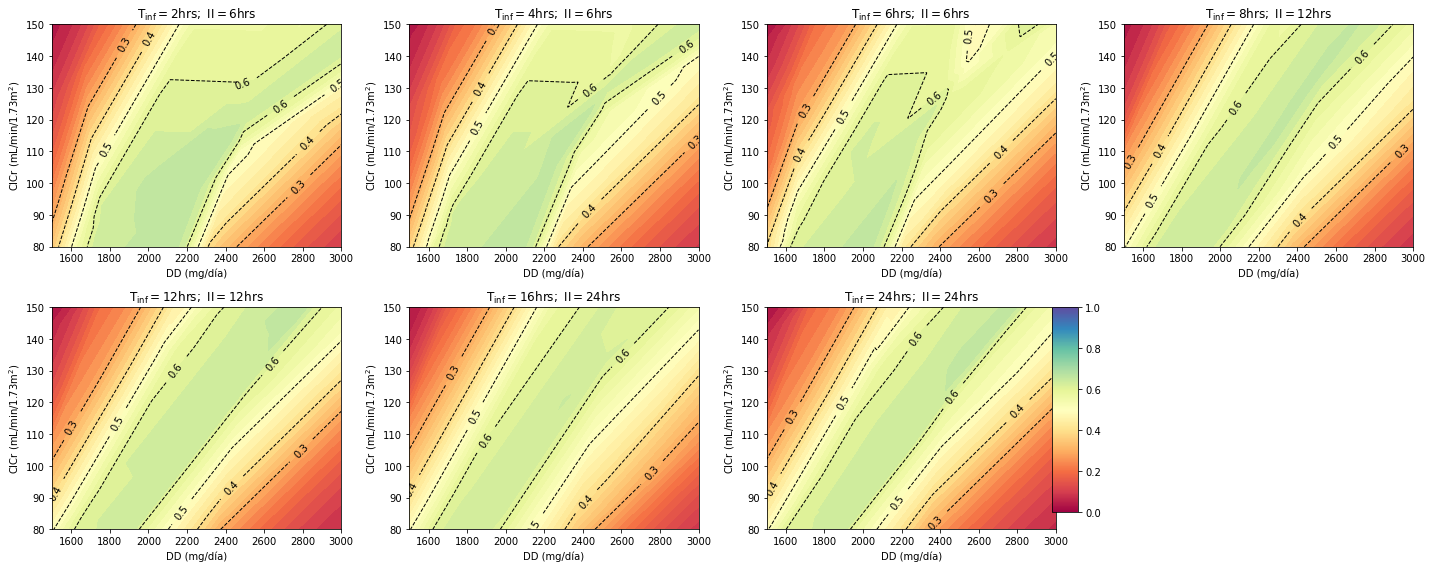

In [49]:
fig = plt.figure(figsize=(20,8), constrained_layout=True)

colscal = PTAColorScaleMatplotlib(umbral=0.85)

tinf_c = [2, 4, 6, 8, 12, 16, 24]
ii_c   = [6, 6, 6, 12, 12,24, 24]
n = 500
# Cambio de la dosis diaria
for i, (j, k) in enumerate( zip( tinf_c, ii_c )):
  ax = plt.subplot(2,4, i+1)

  df = simularANN({'DD': np.linspace(1500, 3000, n), 'CLCR': np.linspace(80, 150, n), 'ii': k, 'tinf': j}, estimator, ordenLista)

  grafico3DContorno(ax, df['x'][1], df['y'][1], df['z'][:, 0].reshape((n,n)), plt.get_cmap('Spectral'),
                    'DD (mg/día)', '$\mathrm{ClCr~(mL/min/1.73m^2)}$', 
                    '$\\mathrm{{T_{{inf}}}} = {0} \\mathrm{{hrs}};~\\mathrm{{II}} = {1} \\mathrm{{hrs}}$'.format(j, k), 
                    levels=30)
  
  cs = ax.contour(df['x'][1], df['y'][1], df['z'][:, 0].reshape((n, n)), levels=[0.3, 0.4, 0.5, 0.6, 0.7], 
                  linewidths=[1], linestyles=('dashed'), colors = 'black')
  ax.clabel(cs, inline=True, fontsize=10, fmt='%1.1f')

  # ax[i].vlines(0, 90, 150, linestyle='dashed')

#plt.colorbar(cm.ScalarMappable(cmap=plt.get_cmap('magma')));
fig.colorbar(cm.ScalarMappable(cmap='Spectral'), ax = ax, location='right', shrink=0.8, panchor = (0.0, 1.5));
fig.set_tight_layout(True)

#fig.suptitle('PTA - Objetivo AUC (400, 600 mg*h/L)\n', va = 'bottom', size=15); 
fig.savefig('106_superficiePTA_CLCR_DD_PTA1.pdf', bbox_inches='tight')
#files.download('/content/106_superficiePTA_CLCR_DD_PTA1.pdf')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning:

This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 

/usr/local/lib/python3.7/dist-packages/IPython/core/events.py:88: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:128: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



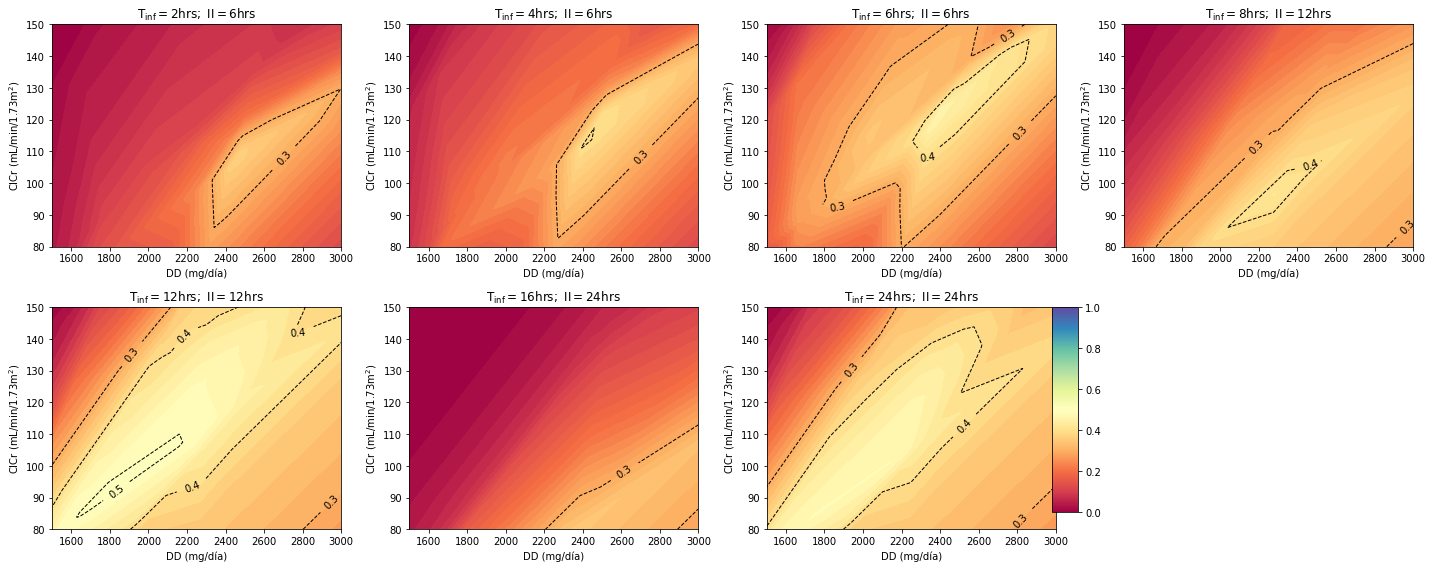

In [50]:
fig = plt.figure(figsize=(20,8), constrained_layout=True)

colscal = PTAColorScaleMatplotlib(umbral=0.85)

tinf_c = [2, 4, 6, 8, 12, 16, 24]
ii_c   = [6, 6, 6, 12, 12,24, 24]
n = 600

# Cambio de la dosis diaria
for i, (j, k) in enumerate(zip(tinf_c, ii_c)):
  ax = plt.subplot(2,4, i+1)
  
  df = simularANN({'DD': np.linspace(1500, 3000, n), 'CLCR': np.linspace(80, 150, n), 'ii': k, 'tinf': j}, estimator, ordenLista)

  grafico3DContorno(ax, df['x'][1], df['y'][1], df['z'][:, 1].reshape((n,n)), plt.get_cmap('Spectral'),
                    'DD (mg/día)', '$\mathrm{ClCr~(mL/min/1.73m^2)}$', 
                    '$\\mathrm{{T_{{inf}}}} = {0} \\mathrm{{hrs}};~\\mathrm{{II}} = {1} \\mathrm{{hrs}}$'.format(j, k), 
                    levels=30)
  
  cs = ax.contour(df['x'][1], df['y'][1], df['z'][:, 1].reshape((n, n)), levels=[0.3, 0.4, 0.5, 0.6], 
                  linewidths=[1], linestyles=('dashed'), colors = 'black')
  ax.clabel(cs, inline=True, fontsize=10, fmt='%1.1f')

  # ax[i].vlines(0, 90, 150, linestyle='dashed')

fig.colorbar(cm.ScalarMappable(cmap=plt.get_cmap('Spectral')), location='right', shrink=0.8, panchor = (0.0, 1.5));
fig.set_tight_layout(True)

#fig.suptitle('PTA - Objetivo Cmin (15, 20 mg/L)\n', va = 'bottom', size=15); 
fig.savefig('107_superficiePTA_CLCR_DD_PTA2.pdf', bbox_inches='tight') 
#files.download('/content/107_superficiePTA_CLCR_DD_PTA2.pdf')

In [51]:
from google.colab import files

files_to_download = [
  "/content/100_Error_Entrenamiento_ANN_MSE.pdf",
  "/content/100_Error_Entrenamiento_ANN_MAE.pdf",
  "/content/100_Error_Entrenamiento_ANN_MAPE.pdf",
  "/content/100_BondadAjuste_ANN.pdf",
  "/content/101_superficiePTA_dosis_MIC1.html",
  "/content/102_superficiePTA_dosis_MIC2.html",
  "/content/103_superficiePTA_dosis_MIC3.html",
  "/content/104_superficiePTA_dosis_MIC4.html",
  "/content/105_superficiePTA_dosis_MIC5.html",
  "/content/106_superficiePTA_CLCR_DD_PTA1.pdf",
  "/content/107_superficiePTA_CLCR_DD_PTA2.pdf"
 ]

[files.download(i) for i in files_to_download]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[None, None, None, None, None, None, None, None, None, None, None]

## Explicación de importancia de predictores

In [52]:
perm = PermutationImportance(estimator, random_state=1).fit(X_train, y_train)
eli5.show_weights(perm, feature_names = X_train.columns.tolist())

Weight,Feature
0.1387 ± 0.0021,DD
0.0790 ± 0.0028,II
0.0550 ± 0.0010,CLCR
0.0274 ± 0.0017,tinf


In [53]:
# Toca extraer el modelo del wrapper de Scikit
explainer = shap.KernelExplainer(model = estimator.model.predict, data = X_train.iloc[0:50, :], link = "identity")

In [54]:
X_idx = 0
shap_value_single = explainer.shap_values(X = X_train.iloc[X_idx:X_idx+1,:], nsamples = 100)
shap_value_single

  0%|          | 0/1 [00:00<?, ?it/s]

[array([[-0.22338884,  0.01150992,  0.00263884, -0.03450572]]),
 array([[ 0.00112955,  0.03888084, -0.00562681, -0.0071238 ]])]

In [55]:
X_muestra = X_train.sample(400)
shap_values = explainer.shap_values(X = X_muestra, nsamples = 400)

  0%|          | 0/400 [00:00<?, ?it/s]

In [56]:
# X_muestra
np.save("100_shape_values", shap_values)
X_muestra.to_csv('100_Xtrain.csv', index=False)

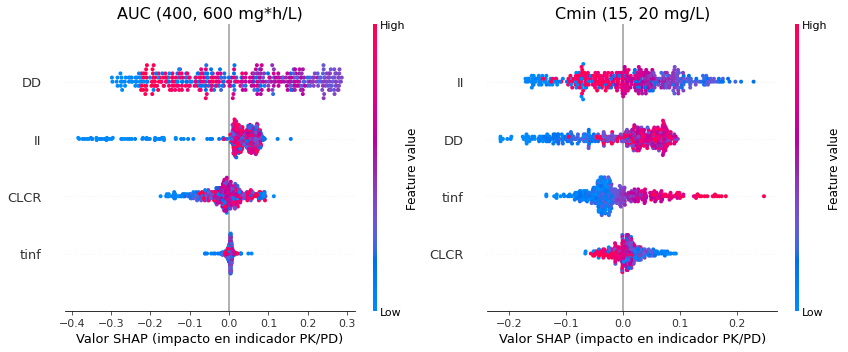

In [57]:
list_titulos = ['AUC (400, 600 mg*h/L)', 'Cmin (15, 20 mg/L)']

fig = plt.figure(figsize=(12, 5))
for i in range(2):
  plt.subplot(1,2,i+1)
  shap.summary_plot(shap_values = shap_values[i], features = X_muestra, show=False, plot_size=None, sort=True)
  ax = plt.gca()
  ax.set_xlabel('Valor SHAP (impacto en indicador PK/PD)')
  ax.set_title(list_titulos[i], fontdict={"size": 16})
fig.set_tight_layout(True)

plt.savefig('108_shapValuesPTA_AUCMIC.pdf')

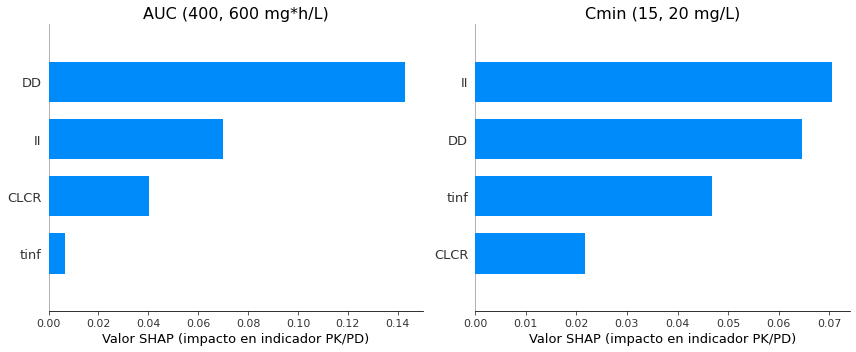

In [58]:
list_titulos = ['AUC (400, 600 mg*h/L)', 'Cmin (15, 20 mg/L)']

fig = plt.figure(figsize=(12, 5))
for i in range(2):
  plt.subplot(1,2,i+1)
  shap.summary_plot(shap_values = shap_values[i], features = X_muestra, show=False, 
                    plot_size=None, sort=True, plot_type="bar")
  ax = plt.gca()
  ax.set_xlabel('Valor SHAP (impacto en indicador PK/PD)')
  ax.set_title(list_titulos[i], fontdict={"size": 16})
fig.set_tight_layout(True)

plt.savefig('109_shapValuesPTA_AUCMIC.pdf')

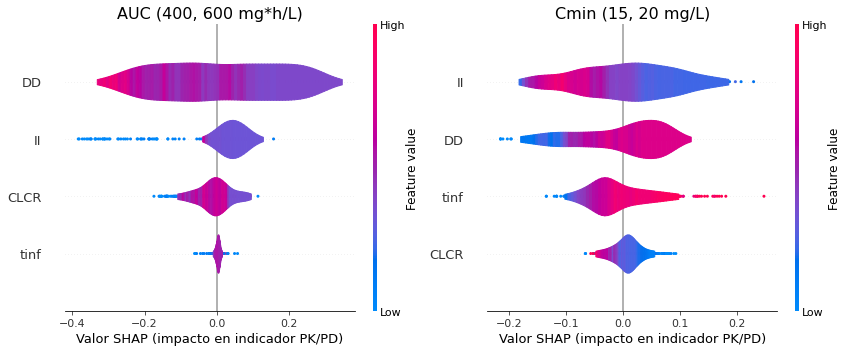

In [59]:
list_titulos = ['AUC (400, 600 mg*h/L)', 'Cmin (15, 20 mg/L)']

fig = plt.figure(figsize=(12, 5))
for i in range(2):
  plt.subplot(1,2,i+1)
  shap.summary_plot(shap_values = shap_values[i], features = X_muestra, show=False, 
                    plot_size=None, sort=True, plot_type="violin")
  ax = plt.gca()
  ax.set_xlabel('Valor SHAP (impacto en indicador PK/PD)')
  ax.set_title(list_titulos[i], fontdict={"size": 16})
fig.set_tight_layout(True)

plt.savefig('110_shapValuesPTA_AUCMIC.pdf')

In [60]:
shap.plots.initjs()
shap.force_plot(0, shap_values[0], 
                feature_names=['DD', 'II', 'tinf', 'CLCR'])

In [61]:
from google.colab import files

files_to_download = [
  "/content/108_shapValuesPTA_AUCMIC.pdf",
  "/content/109_shapValuesPTA_AUCMIC.pdf",
  "/content/110_shapValuesPTA_AUCMIC.pdf"
 ]

[files.download(i) for i in files_to_download]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[None, None, None]

In [62]:
X_todos = X_train.copy()
X_todos['AUC']  = [i for i, _ in estimator.predict(X_train)]
X_todos['Cmin'] = [j for _, j in estimator.predict(X_train)]
X_todos

,DD,II,tinf,CLCR,AUC,Cmin
642,3968.690790,15.591041,7.841883,109.278119,0.026916,1.834085e-01
700,3718.798011,11.951572,2.595734,101.798616,0.043692,2.277662e-01
226,1633.294204,3.800312,2.799089,102.909662,0.000016,1.441316e-08
1697,3732.154079,15.753397,10.173476,103.493778,0.038351,2.180294e-01
1010,2817.733540,18.866553,12.151841,122.139969,0.454160,2.632836e-01
...,...,...,...,...,...,...
1638,1212.662438,22.099702,13.735451,120.711410,0.021024,3.887713e-04
1095,1480.786207,8.085458,6.098704,93.021450,0.360682,2.087406e-01
1130,2791.535486,10.935504,4.447966,144.088872,0.608064,1.911327e-01
1294,3333.475949,15.176673,12.949575,137.447909,0.319552,3.446984e-01


In [63]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

label_dict = {'x': 'PTA AUC (400-600 mg*h/L)', 'y': 'PTA Cmin (15-20 mg/L)'}

fig = make_subplots(
    rows=2, cols=2,
    column_widths=[0.5, 0.5],
    row_heights=[0.5, 0.5],
    x_title = label_dict['x'],
    y_title = label_dict['y'],
    specs=[[{"type": "scatter"}, {"type": "scatter"}],
           [{"type": "scatter"}, {"type": "scatter"}]])

fig.add_trace(
    go.Scatter(x = X_todos['AUC'], y = X_todos["Cmin"], mode = 'markers', 
               marker = {'color': X_todos['DD']}, name='DD'),row = 1, col = 1)

fig.add_trace(
    go.Scatter(x = X_todos['AUC'], y = X_todos["Cmin"], mode = 'markers', 
               marker = {'color': X_todos['II']}, name='II'), row = 1, col = 2)
fig.add_trace(
    go.Scatter(x = X_todos['AUC'], y = X_todos["Cmin"], mode = 'markers', 
               marker = {'color': X_todos['tinf']}, name='Tinf'), row = 2, col = 1)
fig.add_trace(
    go.Scatter(x = X_todos['AUC'], y = X_todos["Cmin"], mode = 'markers', 
               marker = {'color': X_todos['CLCR']}, name='CLCR'), row = 2, col = 2)

for i in range(2):
  for j in range(2):
    fig.update_xaxes(range=[0.0, 0.7], row=i, col=j)
    fig.update_yaxes(range=[0.0, 0.7], row=i, col=j)

fig.write_html("111_ComparativoIndicadoresPKPD.html")
files.download('/content/111_ComparativoIndicadoresPKPD.html')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>